In [1]:
using SparseArrays

using ReinforcementLearning, ReinforcementLearningEnvironments, RLIntro.RandomWalk
using StatsBase, Plots

In [2]:
ACTIONS = collect(Iterators.flatten((-100:-1, 1:100)))
NS = 1002
NA = length(ACTIONS)

200

Here we define a group mapping preprocessor first.

The first and the last element will be grouped into another two separate group.

In [3]:
Base.@kwdef struct GroupMapping <: AbstractPreprocessor
    n::Int
    n_groups::Int
    n_per_group::Int=div(n, n_groups)
end

function (p::GroupMapping)(x::Int)
    if x == 1
        1
    elseif x == p.n
        p.n_groups + 2
    else
        div(x - 2, p.n_per_group) + 2
    end
end

And then define a hook to calculate the count of each state.

In [4]:
struct CountStates <: AbstractHook
    counts::Vector{Int}
    CountStates(n) = new(zeros(Int, n))
end

(f::CountStates)(::PreActStage, agent, env, obs_action) = f.counts[get_state(observe(env.env))] += 1

In [5]:
env = RandomWalkEnv(N=NS, actions=ACTIONS)

RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{Int64}(1, 1002, 1002), DiscreteSpace{Int64}(1, 200, 200))

In [6]:
observe(env)

Observation{Float64,Bool,Int64,NamedTuple{(),Tuple{}}}(0.0, false, 501, NamedTuple())

In [7]:
TRUE_STATE_VALUES = begin
    env = RandomWalkEnv(N=NS, actions=ACTIONS)
    agent = Agent(
        π=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularVApproximator(NS),
                method=:SRS,
                optimizer=Descent(0.01)
                ),
            f=TabularRandomPolicy(fill(1/NA, NS, NA))
            ),
        buffer=episode_RTSA_buffer()
    )
    run(agent, env, StopAfterEpisode(10^5))
    agent.π.learner.approximator.table
end

Progress:   0%|                                         |  ETA: 1 days, 12:04:23
4m  TRAINING/EPISODE:  0
Progress:  54%|██████████████████████▏                  |  ETA: 0:00:02
4m  TRAINING/EPISODE:  662
Progress:  62%|█████████████████████████▋               |  ETA: 0:00:01
4m  TRAINING/EPISODE:  765
Progress:  70%|████████████████████████████▌            |  ETA: 0:00:01
4m  TRAINING/EPISODE:  856
Progress:  85%|██████████████████████████████████▊      |  ETA: 0:00:00
4m  TRAINING/EPISODE:  1035
Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:00
4m  TRAINING/EPISODE:  1161
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  TRAINING/EPISODE:  1219


1002-element Array{Float64,1}:
  0.0               
 -0.9086269428517919
 -0.909978951806494 
 -0.8922399088513284
 -0.9058998900578941
 -0.9012548201559113
 -0.9199031255344642
 -0.907919985886104 
 -0.8973014226641467
 -0.8996560938437366
 -0.901500452972025 
 -0.8982048793513512
 -0.9059389353145381
  ⋮                 
  0.8990162964412833
  0.9023599657988591
  0.8960707536885225
  0.8968256669160055
  0.89300750612557  
  0.8940416065191308
  0.9005433046318455
  0.8969991881858167
  0.9077429137128834
  0.899032679041344 
  0.9075186669539161
  0.0               

In [9]:
using Plots

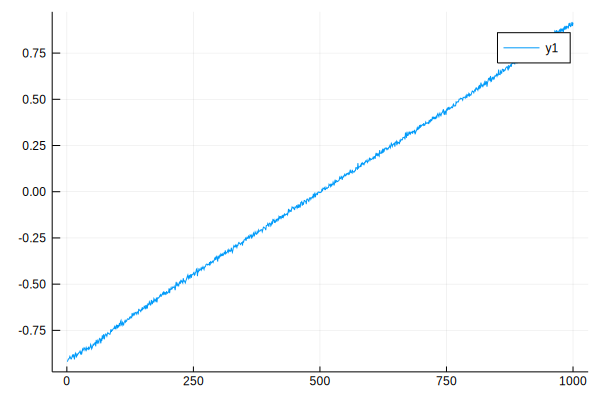

In [17]:
plot(TRUE_STATE_VALUES[2:end-1])

In [8]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

function (f::RecordRMS)(::PostEpisodeStage, agent, env, obs)
    push!(f.rms, sqrt(mean((agent.π.learner.approximator.(env.preprocessor.(2:(NS-1))) - TRUE_STATE_VALUES[2:end-1]).^2)))
end

In [39]:
n_groups = 10
env = WrappedEnv(
    env=RandomWalkEnv(N=NS, actions=ACTIONS),
    preprocessor=GroupMapping(n=NS, n_groups=n_groups)
    )

WrappedEnv{RandomWalkEnv,GroupMapping}(RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{Int64}(1, 1002, 1002), DiscreteSpace{Int64}(1, 200, 200)), GroupMapping(1002, 10, 100))

In [42]:
agent = Agent(
    π=VBasedPolicy(
        learner=MonteCarloLearner(
            approximator=TabularVApproximator(n_groups+2),
            kind=EVERY_VISIT,  # this is very important!
            α=2e-5),
        f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
        ),
    buffer=episode_RTSA_buffer()
)

Agent{VBasedPolicy{MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling},TabularRandomPolicy},EpisodeTurnBuffer{(:reward, :terminal, :state, :action),Tuple{Float64,Bool,Int64,Int64},NamedTuple{(:reward, :terminal, :state, :action),Tuple{Array{Float64,1},Array{Bool,1},Array{Int64,1},Array{Int64,1}}}},Symbol}(VBasedPolicy{MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling},TabularRandomPolicy}(MonteCarloLearner{ReinforcementLearning.EveryVisit,TabularVApproximator,CachedSampleAvg,ReinforcementLearning.NoSampling}(TabularVApproximator([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 1.0, 2.0e-5, CachedSampleAvg(Dict{Any,SampleAvg}())), TabularRandomPolicy([0.005 0.005 … 0.005 0.005; 0.005 0.005 … 0.005 0.005; … ; 0.005 0.005 … 0.005 0.005; 0.005 0.005 … 0.005 0.005])), NamedTuple{(:reward, :terminal, :state, :action),Tuple{Float64,Bool,Int

In [43]:
hook=CountStates(NS)
run(agent, env, StopAfterEpisode(10^5);hook=hook)

Progress:   0%|                                         |  ETA: 4:32:44
4m  TRAINING/EPISODE:  0
Progress:  37%|███████████████▎                         |  ETA: 0:00:00
4m  TRAINING/EPISODE:  437
Progress:  75%|██████████████████████████████▉          |  ETA: 0:00:00
4m  TRAINING/EPISODE:  878
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  1161


CountStates([0, 1260, 1192, 1231, 1265, 1324, 1381, 1360, 1408, 1427  …  1460, 1320, 1366, 1333, 1285, 1288, 1216, 1245, 1236, 0])

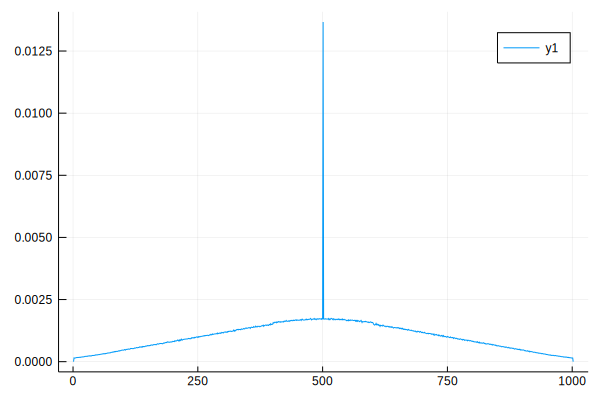

In [44]:
plot(hook.counts./sum(hook.counts))

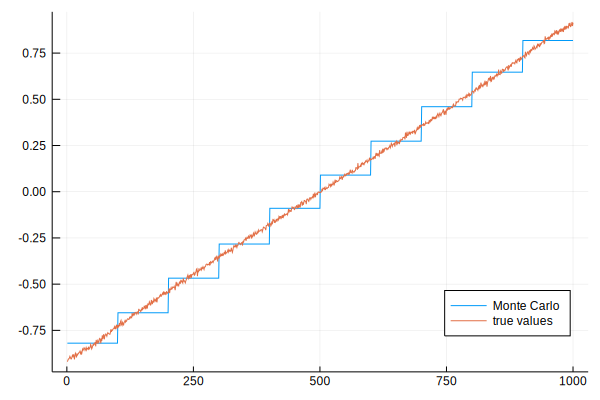

In [48]:
plot(agent.π.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="Monte Carlo")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [49]:
agent = Agent(
    π=VBasedPolicy(
        learner=TDLearner(
                approximator=TabularVApproximator(n_groups+2),
                method=:SRS,
                optimizer=Descent(2e-4)
                ),
        f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
        ),
    buffer=episode_RTSA_buffer()
)
run(agent, env, StopAfterEpisode(10^5))

Progress:  12%|████▉                                    |  ETA: 0:00:01
4m  TRAINING/EPISODE:  129
Progress:  41%|████████████████▊                        |  ETA: 0:00:00
4m  TRAINING/EPISODE:  458
Progress:  70%|████████████████████████████▉            |  ETA: 0:00:00
4m  TRAINING/EPISODE:  820
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  1173


EmptyHook()

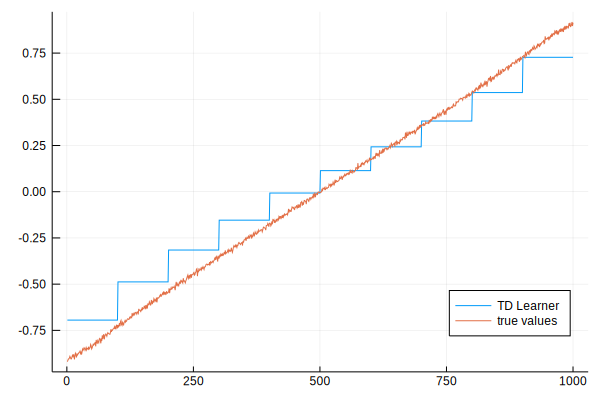

In [51]:
plot(agent.π.learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="TD Learner")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [53]:
using StatsBase

Progress:  10%|████▏                                    |  ETA: 0:00:05
4m  TRAINING/EPISODE:  0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
  TRAINING/EPISODE:  0


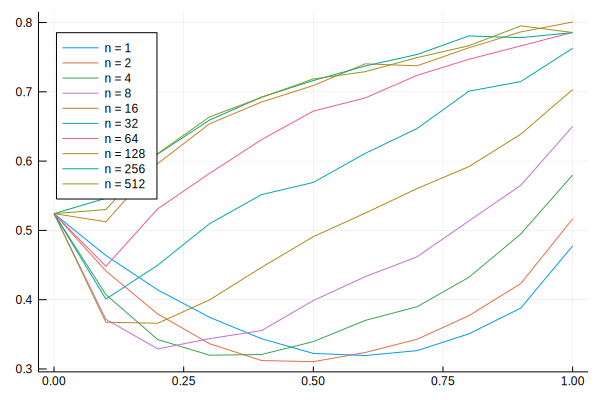

In [33]:
n_groups = 20
function run_once(n, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=GroupMapping(n=NS, n_groups=n_groups)
        )
    agent = Agent(
        π=VBasedPolicy(
            learner=TDLearner(
                approximator=TabularVApproximator(n_groups+2),
                method=:SRS,
                optimizer=Descent(α),
                n=n
                ),
            f=TabularRandomPolicy(fill(1/NA, n_groups+2, NA))
            ),
        buffer=episode_RTSA_buffer()
    )

    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(10); hook=hook)
    mean(hook.rms)
end

A = 0:0.1:1

p = plot(legend=:topleft)
for n in [2^i for i in 0:9]
    plot!(p, A, mean([run_once(n, α) for α in A] for _ in 1:100), label="n = $n")
end
p

In [36]:
struct ScalePreprocessor <: AbstractPreprocessor
    scale::Float64
end

(p::ScalePreprocessor)(x::Number) = p.scale * x


In [34]:
π_target = TabularRandomPolicy(fill(1/NA, NS, NA))

function run_once_MC(preprocessor, order, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        π=VBasedPolicy(
            learner=MonteCarloLearner(
                approximator=LinearVApproximator(zeros(order+1)),
                α=α,
                kind=EVERY_VISIT
                ),
            f=obs -> obs.meta.state_before_ScalePreprocessor |> π_target
            ),
        buffer=episode_RTSA_buffer(;state_eltype=Vector{Float64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(5000;is_show_progress=false); hook=hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

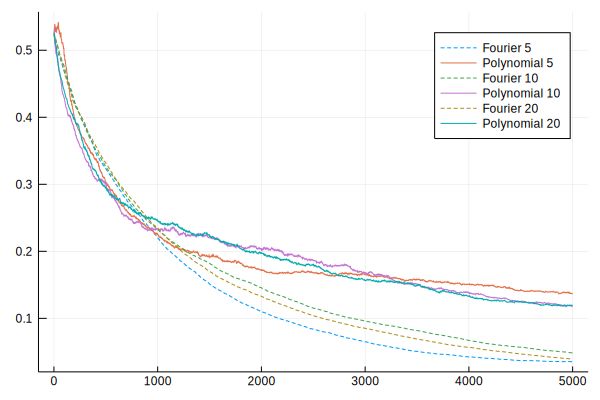

In [38]:
p = plot(legend=:topright)
for order in [5, 10, 20]
    plot!(p, mean(run_once_MC(Chain(ScalePreprocessor(1/NS), FourierPreprocessor(order)), order, 0.00005) for _ in 1:1), label="Fourier $order", linestyle=:dash)
    plot!(p, mean(run_once_MC(Chain(ScalePreprocessor(1/NS), PolynomialPreprocessor(order)), order, 0.0001) for _ in 1:1), label="Polynomial $order", linestyle=:solid)
end
p

In [28]:
function run_once_MC(preprocessor, α, V)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        π=VBasedPolicy(
            learner=MonteCarloLearner(
                approximator=LinearVApproximator(V),
                α=α,
                kind=EVERY_VISIT
                ),
            f=obs -> rand(1:NA)
            ),
        buffer=episode_RTSA_buffer(;state_eltype=SparseMatrixCSC{Float64,Int64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(10000;is_show_progress=false); hook=hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

In [29]:
struct ToSparseMatrixPreprocessor <: AbstractPreprocessor
    m::Int
    n::Int
end

(p::ToSparseMatrixPreprocessor)(xs::Vector{Int}) = sparse(xs, 1:length(xs), ones(length(xs)), p.m, p.n)

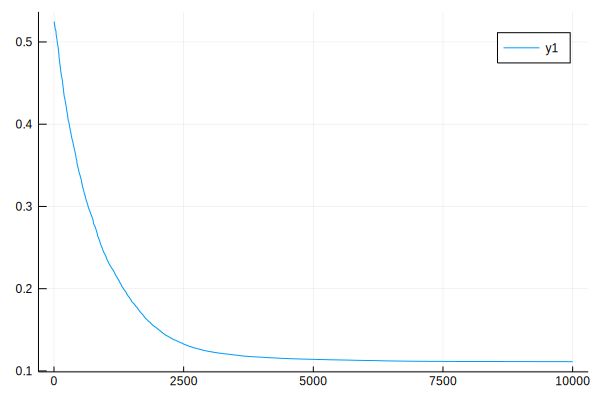

In [30]:
plot(run_once_MC(
    Chain(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:1]),
        ToSparseMatrixPreprocessor(7, 1)
        ),
    1e-4/1,
    zeros(7,1)))

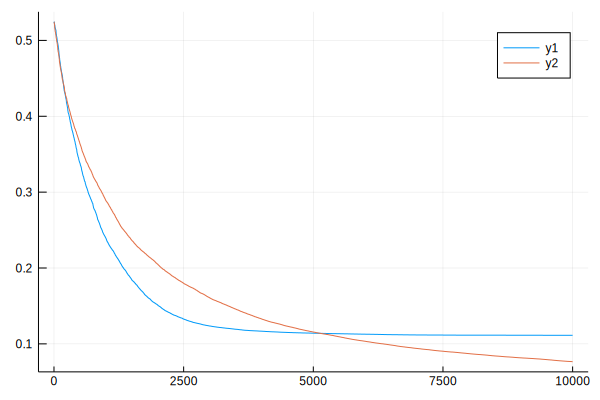

In [31]:
plot!(run_once_MC(
    Chain(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:50]),
        ToSparseMatrixPreprocessor(7, 50)
        ),
    1e-4/50,
    zeros(7,50)))